# TP3 : Accélération de la méthode BEM pour l’équation de Helmholtz 2D : algorithmes de factorisation de rang faible

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from scipy.special import roots_legendre, jv, hankel1
import time
from functools import partial

%matplotlib inline
plt.rcParams['figure.dpi']= 100

## Génération matrices low-rank

In [2]:
def lowRankMatrices(m,n,r):
    if r*(m+n) >= m*n:
        return "erreur : rang trop grand"
    else:
        u = np.random.rand(m,r)
        v = np.random.rand(n,r)
        M = u @ v.T
        return M

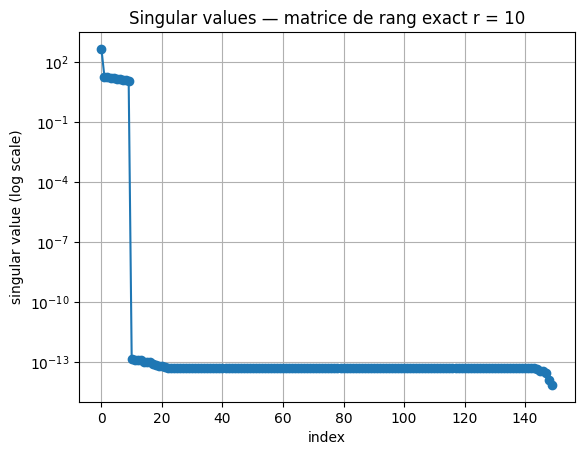

In [3]:
m = 200
n = 150
r = 10

M = lowRankMatrices(m,n,r)

############### plot décroissance valeurs singulières ###############

U,S,Vh = np.linalg.svd(M)
plt.figure()
plt.semilogy(S, marker='o')
plt.title("Singular values — matrice de rang exact r = " +str(r))
plt.xlabel("index")
plt.ylabel("singular value (log scale)")
plt.grid(True)
plt.show()

## Méthode SVD tronquée

In [4]:
def SVD_tronquee(A,k):
    U,S,Vh = np.linalg.svd(A)
    Uk = U[:,:k]
    Sk = S[:k]
    Vhk = Vh[:k,:]
    Ak = Uk @ np.diag(Sk) @ Vhk
    return Ak, S

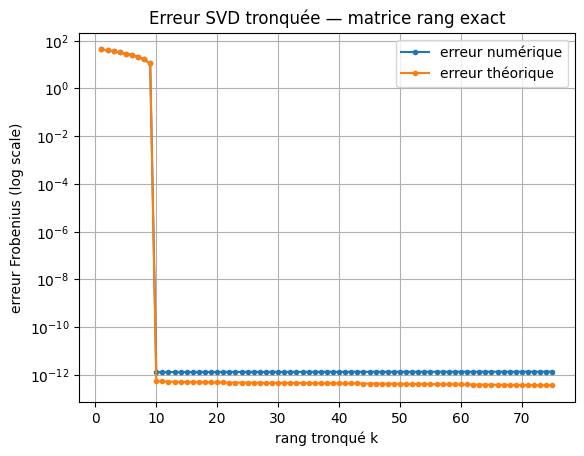

In [5]:
m = 200
n = 150
r = 10

M = lowRankMatrices(m,n,r)

############### plot erreur commise par svd en fonction du rang numérique choisi ###################

erreur = []
erreurReelle = []
K = np.arange(1,min(n,m)//2+1, dtype=int)
for k in K:
    Mk,s = SVD_tronquee(M,k)
    e = np.linalg.norm(M-Mk, ord='fro')
    erreur.append(e)
    eReelle = np.sqrt(np.sum(s[k:]**2))
    erreurReelle.append(eReelle)

plt.figure()
plt.plot(K, erreur, marker='.', label='erreur numérique')
plt.plot(K, erreurReelle, marker='.', label='erreur théorique')
plt.yscale('log')
plt.title("Erreur SVD tronquée — matrice rang exact")
plt.xlabel("rang tronqué k")
plt.ylabel("erreur Frobenius (log scale)")
plt.legend()
plt.grid(True)
plt.show()

## Méthode ACA avec pivotage complet

In [6]:
def fully_pivoted_cross_approximation(A, epsilon=1e-8, max_rank=None, verbose=False):
    m, n = A.shape
    if max_rank is None:
        max_rank = min(m, n)

    R = A.copy().astype(complex)
    U_cols = []
    V_cols = []

    normA = np.linalg.norm(A)

    for k in range(max_rank):

        i_star, j_star = divmod(np.argmax(np.abs(R)), n)
        delta_k = R[i_star, j_star]

        if verbose:
            print(f"[{k}] Pivot = R[{i_star},{j_star}] = {delta_k}")

        if abs(delta_k) < epsilon * normA:
            if verbose:
                print("Pivot trop petit → arrêt")
            break

        U_k = R[:, j_star].copy()

        V_k = R[i_star, :].copy() / delta_k

        U_cols.append(U_k)
        V_cols.append(V_k)

        R -= np.outer(U_k, V_k)

        if verbose:
            print(f"   Rang {k+1} : contribution = {np.linalg.norm(U_k)*np.linalg.norm(V_k)}")

        if np.linalg.norm(np.outer(U_k, V_k)) < epsilon * normA:
            if verbose:
                print("Contribution trop petite → arrêt")
            break

    if len(U_cols) == 0:
        return np.zeros((m, 0), dtype=complex), np.zeros((n, 0), dtype=complex)

    U = np.column_stack(U_cols)
    V = np.column_stack(V_cols)

    return U, V

In [7]:
m = 200
n = 150
r = 10

M = lowRankMatrices(m,n,r)

################ test ACA totale ##################

# Exécution ACA complet
U, V = fully_pivoted_cross_approximation(M, epsilon=1e-10)

# # Erreur théorique (SVD tronquée)
# sv = np.linalg.svd(M, compute_uv=False)
# theoretical = [np.sqrt(np.sum(sv[k:]**2)) for k in range(1, len(errors)+1)]

# # Tracé
# plt.figure()
# plt.plot(np.arange(1, len(errors)+1), errors, marker='.', label='erreur numérique')
# plt.plot(np.arange(1, len(theoretical)+1), theoretical, marker='.', label='erreur théorique')
# plt.yscale('log')
# plt.xlabel("rang tronqué k")
# plt.ylabel("erreur Frobenius (log scale)")
# plt.title("Fully-pivoted Cross Approximation")
# plt.legend()
# plt.grid(True)
# plt.show()

## Méthode ACA avec pivotage partiel

In [8]:
def partially_pivoted_cross_approximation(A, epsilon=1e-6, kmax=None):
    m, n = A.shape
    if kmax is None:
        kmax = min(m, n)//2
    
    # Listes pour stocker les vecteurs u_k (colonnes) et v_k (lignes)
    U = []
    V = []
    
    # (c) Suivi des lignes et colonnes déjà utilisées pour le pivot
    used_rows = np.zeros(m, dtype=bool)
    used_cols = np.zeros(n, dtype=bool)
    
    # (d) Initialisation pour le critère de convergence
    norm_A_k_F_squared = 0.0  # Norme de Frobenius de l'approx. au carré
    
    k = 0 # Rang actuel
    
    for k in range(kmax):
        
        # --- Étape (a) et (c) : Sélection du pivot (partiel) ---
        
        # On choisit la première ligne non encore utilisée
        i_k = -1
        for i in range(m):
            if not used_rows[i]:
                i_k = i
                break
        
        # Si toutes les lignes sont utilisées, on s'arrête
        if i_k == -1:
            break
            
        used_rows[i_k] = True
        
        # --- Étape (b) : Calcul de la ligne du résidu SANS assembler R ---
        
        # R_k_row = A[i_k, :] - sum(U[l][i_k, 0] * V[l] pour l < k)
        R_k_row = A[i_k, :].copy().reshape(1, -1)  # (1, n)
        for l in range(k):
            # U[l][i_k, 0] est un scalaire
            # V[l] est un vecteur ligne (1, n)
            R_k_row -= U[l][i_k, 0] * V[l]
            
        # --- Étape (a) et (c) : Trouver le pivot max dans cette ligne ---
        
        # On cherche le max en valeur absolue sur les colonnes non utilisées
        j_k = -1
        max_abs_val = -1.0
        for j in range(n):
            if not used_cols[j]:
                abs_val = np.abs(R_k_row[0, j])
                if abs_val > max_abs_val:
                    max_abs_val = abs_val
                    j_k = j
                    
        # Si toutes les colonnes sont utilisées ou le pivot est nul
        if j_k == -1 or max_abs_val < 1e-15:
            used_rows[i_k] = False # On annule, cette ligne n'a pas servi
            break
            
        used_cols[j_k] = True
        
        # --- Étape (b) : Calcul des vecteurs u_k et v_k ---
        
        delta_k = R_k_row[0, j_k] # Le pivot
        
        # v_k est la ligne du résidu normalisée
        v_k = R_k_row / delta_k  # shape (1, n)
        
        # Calcul de la colonne u_k du résidu SANS assembler R
        # u_k = A[:, j_k] - sum(U[l] * V[l][0, j_k] pour l < k)
        u_k = A[:, j_k].copy().reshape(-1, 1)  # shape (m, 1)
        for l in range(k):
            # U[l] est un vecteur colonne (m, 1)
            # V[l][0, j_k] est un scalaire
            u_k -= U[l] * V[l][0, j_k]
            
        # On stocke les nouveaux vecteurs
        U.append(u_k)
        V.append(v_k)
        
        # --- Étape (d) : Critère de convergence (non stagnation) ---
        
        norm_uk_sq = np.sum(u_k**2)  # ||u_k||^2
        norm_vk_sq = np.sum(v_k**2)  # ||v_k||^2
        norm_uv_k_sq = norm_uk_sq * norm_vk_sq # ||u_k v_k||_F^2
        
        cross_term = 0.0
        for l in range(k):
            # u_l.T @ u_k est un produit scalaire (scalaire)
            ul_T_uk = (U[l].T @ u_k)[0, 0] 
            # v_l @ v_k.T est un produit scalaire (scalaire)
            vl_vk_T = (V[l] @ v_k.T)[0, 0]
            cross_term += ul_T_uk * vl_vk_T
            
        # Mise à jour de la norme au carré de l'approximation A_k
        norm_A_k_F_squared += 2 * cross_term + norm_uv_k_sq
        norm_A_k_F = np.sqrt(norm_A_k_F_squared)
        
        # Le critère de non-stagnation
        norm_uv_k = np.sqrt(norm_uv_k_sq)
        
        # On arrête si la norme du nouveau terme est petite par rapport à la norme totale de l'approximation
        if norm_uv_k <= epsilon * norm_A_k_F and k > 0:
            break
            
    return U, V

# --- Fonction utilitaire pour reconstruire la matrice ---
def reconstruct_from_uv(U, V):
    if len(U)==0:
        return np.array([[]]) # Cas vide
    
    m, _ = U[0].shape
    _, n = V[0].shape
    A_approx = np.zeros((m, n), dtype=np.complex128)
    
    for k in range(len(U)):
        # u_k @ v_k est un produit externe (outer product)
        A_approx += U[k] @ V[k] 
        
    return A_approx

In [9]:
# 1. Créer une matrice de rang faible (rang 5)
m, n = 100, 50
r = 20
A = lowRankMatrices(m,n,r)

# Ajouter un peu de bruit (optionnel)
# A += 0.01 * np.random.randn(m, n)

# 2. Lancer l'ACA
# Nous utilisons une tolérance assez faible
U_factors, V_factors = partially_pivoted_cross_approximation(A, epsilon=1e-10)

k_found = len(U_factors)-1
print(f"Rang trouvé par l'ACA : {k_found}")

# 3. Reconstruire la matrice
A_approx = reconstruct_from_uv(U_factors, V_factors)

# 4. Vérifier l'erreur
norm_A = np.linalg.norm(A)
norm_diff = np.linalg.norm(A - A_approx)
relative_error = norm_diff / norm_A

print(f"Norme de A : {norm_A:.4e}")
print(f"Norme de la différence (erreur) : {norm_diff:.4e}")
print(f"Erreur relative : {relative_error:.4e}")

# Vérification du rang
print(f"Rang de la matrice originale (numpy) : {np.linalg.matrix_rank(A)}")
print(f"Rang de l'approximation (numpy) : {np.linalg.matrix_rank(A_approx)}")

Rang trouvé par l'ACA : 20
Norme de A : 3.6255e+02
Norme de la différence (erreur) : 2.2291e-13
Erreur relative : 6.1482e-16
Rang de la matrice originale (numpy) : 20
Rang de l'approximation (numpy) : 20


## Fonctions TP2

In [10]:
def generate_nodes(N, a):
    angles = np.linspace(0, 2*np.pi, N, endpoint=False)
    x = a * np.cos(angles)
    y = a * np.sin(angles)
    return angles, np.column_stack((x, y))

def generate_segments_indices(N):
    return [(k, (k+1) % N) for k in range(N)]

def uInc(x,y,k):
    return np.exp(-1j*k*x)

def G(n1,n2,k):
    x1,y1 = n1
    x2,y2 = n2
    z1 = x1 + 1j*y1
    z2 = x2 + 1j*y2
    dist = np.abs(z2-z1)
    # Ajout d'une petite stabilisation si la distance est nulle (même si H0 explose)
    if dist < 1e-15:
        return 0 # G(x,x) est infini, géré séparément
    return 1j*hankel1(0,k*dist)/4

def GaussLegendre(f,a,b,points,poids):
    n = len(points)
    x, w = points, poids
    S = 0.0
    for i in range(n):
        t = x[i]
        u = (b-a)/2*t + (b+a)/2
        S += w[i]*f(u)
    return (b-a)/2*S

def integrale2D(f,n1,n2,points,poids): 
    x1,y1 = n1[0],n1[1]
    x2,y2 = n2[0],n2[1]
    norm = np.sqrt((x2-x1)**2 + (y2-y1)**2)
    def g(t):
        X = x1*(1-t)+x2*t
        Y = y1*(1-t)+y2*t
        return f(X,Y)*norm
    return GaussLegendre(g,0,1,points,poids)

def matriceA(N,segments,nodes,G_func,points,poids,k):
    A = np.zeros((N,N),dtype=np.complex128)
    for i in range(N): # Segments "ex" (observation)
        seg_i_n1 = nodes[i]
        seg_i_n2 = nodes[(i+1)%N]
        
        for j in range(N): # Segments "ey" (source)
            seg_j_n1 = nodes[j]
            seg_j_n2 = nodes[(j+1)%N]

            if i==j:
                coeff = -1/(2*np.pi)
                
                # Coordonnées des nœuds du segment
                x1, y1 = seg_j_n1
                x2, y2 = seg_j_n2
                long = np.sqrt((x2-x1)**2 + (y2-y1)**2)

                # Fonctions de distance
                d_j = lambda x,y: np.sqrt((x1-x)**2 + (y1-y)**2)
                d_j_plus_1 = lambda x,y: np.sqrt((x2-x)
                                                 **2 + (y2-y)**2)
                
                # Partie singulière (intégrale analytique de log|x-y|)
                f = lambda x,y: coeff * (
                    d_j_plus_1(x,y) * np.log(d_j_plus_1(x,y) + 1e-15) + 
                    d_j(x,y) * np.log(d_j(x,y) + 1e-15) - long
                )
                A[i][j] += integrale2D(f, seg_i_n1, seg_i_n2, points, poids)

                # Partie régulière
                const = 1j/4 + coeff*(np.log(k/2)+np.euler_gamma)
                # Intégrale de la constante 1 (longueur du segment j)
                long_j = integrale2D(lambda x,y: 1.0, seg_j_n1, seg_j_n2, points, poids)
                # On intègre cette constante sur le segment i
                A[i][j] += integrale2D(lambda x,y: const * long_j, seg_i_n1, seg_i_n2, points, poids)
            
            else:
                # Double intégrale régulière
                I_inner = lambda X,Y: integrale2D(
                    lambda x,y: G_func((x,y),(X,Y),k), 
                    seg_i_n1, seg_i_n2, points, poids
                )
                A[i][j] += integrale2D(I_inner, seg_j_n1, seg_j_n2, points, poids)
    return A

## Approche (a) : ACA sur la Matrice Assemblée

In [11]:
# --- Paramètres du Problème ---
N = 200      # Nombre de noeuds/segments
a = 1.0      # Rayon
k = 2 * np.pi # Nombre d'onde
n_gauss = 2  # Points de Gauss-Legendre
EPS_ACA = 1e-5 # Tolérance pour l'ACA

# --- Initialisation BEM ---
angles, nodes = generate_nodes(N, a)
segments = generate_segments_indices(N)
points, poids = np.polynomial.legendre.leggauss(n_gauss)

print("--- Approche (a): ACA sur Matrice Assemblée ---")

# --- 1. Assemblage complet de la matrice BEM ---
print(f"Assemblage de la matrice BEM complète ({N}x{N})...")
start_time_a_asm = time.time()
A_full = matriceA(N, segments, nodes, G, points, poids, k)
end_time_a_asm = time.time()
print(f"Temps d'assemblage : {end_time_a_asm - start_time_a_asm:.4f} s")

# --- 2. Compression ACA ---
print("Compression de la matrice avec ACA...")
start_time_a_aca = time.time()
U_a, V_a = partially_pivoted_cross_approximation(A_full, epsilon=EPS_ACA, kmax=N)
end_time_a_aca = time.time()
print(f"Temps de compression ACA : {end_time_a_aca - start_time_a_aca:.4f} s")

rang_a = len(U_a)
print(f"\nRang trouvé (Approche a) : {rang_a}")

# --- 3. Vérification de l'erreur ---
A_approx_a = reconstruct_from_uv(U_a, V_a)
norm_A = np.linalg.norm(A_full)
norm_diff = np.linalg.norm(A_full - A_approx_a)
print(f"Erreur relative ||A - A_approx|| / ||A|| : {norm_diff / norm_A:.2e}")
print(f"Temps total (a) : {end_time_a_aca - start_time_a_asm:.4f} s")

--- Approche (a): ACA sur Matrice Assemblée ---
Assemblage de la matrice BEM complète (200x200)...
Temps d'assemblage : 0.5833 s
Compression de la matrice avec ACA...
Temps de compression ACA : 0.0532 s

Rang trouvé (Approche a) : 200
Erreur relative ||A - A_approx|| / ||A|| : 5.11e-16
Temps total (a) : 0.6366 s


### Approches (b) et (c) : ACA "à la volée"

##### Fonctions d'accès "à la volée" pour (c)

In [12]:
def get_bem_entry_c(i, j, N, nodes, G_func, points, poids, k):
    """Calcule une seule entrée A(i, j) de la matrice BEM."""
    
    seg_i_n1 = nodes[i]
    seg_i_n2 = nodes[(i+1)%N]
    seg_j_n1 = nodes[j]
    seg_j_n2 = nodes[(j+1)%N]
    
    entry_val = 0.0 + 0.0j

    if i == j:
        coeff = -1/(2*np.pi)
        x1, y1 = seg_j_n1
        x2, y2 = seg_j_n2
        long = np.sqrt((x2-x1)**2 + (y2-y1)**2)

        d_j = lambda x,y: np.sqrt((x1-x)**2 + (y1-y)**2)
        d_j_plus_1 = lambda x,y: np.sqrt((x2-x)**2 + (y2-y)**2)
        
        f = lambda x,y: coeff * (
            d_j_plus_1(x,y) * np.log(d_j_plus_1(x,y) + 1e-15) + 
            d_j(x,y) * np.log(d_j(x,y) + 1e-15) - long
        )
        entry_val += integrale2D(f, seg_i_n1, seg_i_n2, points, poids)

        const = 1j/4 + coeff*(np.log(k/2)+np.euler_gamma)
        long_j = integrale2D(lambda x,y: 1.0, seg_j_n1, seg_j_n2, points, poids)
        entry_val += integrale2D(lambda x,y: const * long_j, seg_i_n1, seg_i_n2, points, poids)
    
    else:
        I_inner = lambda X,Y: integrale2D(
            lambda x,y: G_func((x,y),(X,Y),k), 
            seg_i_n1, seg_i_n2, points, poids
        )
        entry_val += integrale2D(I_inner, seg_j_n1, seg_j_n2, points, poids)
        
    return entry_val

def get_bem_row_c(i, N, nodes, G_func, points, poids, k):
    """Calcule la ligne i de la matrice BEM."""
    row = np.zeros(N, dtype=np.complex128)
    for j in range(N):
        row[j] = get_bem_entry_c(i, j, N, nodes, G_func, points, poids, k)
    return row

def get_bem_col_c(j, N, nodes, G_func, points, poids, k):
    """Calcule la colonne j de la matrice BEM."""
    col = np.zeros(N, dtype=np.complex128)
    for i in range(N):
        col[i] = get_bem_entry_c(i, j, N, nodes, G_func, points, poids, k)
    return col

##### Algorithme ACA "à la volée"

In [13]:
def aca_partial_pivot_on_the_fly(N, M, get_row_func, get_col_func, eps=1e-6, max_rank=100):
    """
    Version "matrix-free" (à la volée) de l'ACA à pivotage partiel.
    A[i_k, :] est remplacé par get_row_func(i_k)
    A[:, j_k] est remplacé par get_col_func(j_k)
    """
    m, n = M, N # m=lignes, n=colonnes
    U = []
    V = []
    used_rows = np.zeros(m, dtype=bool)
    used_cols = np.zeros(n, dtype=bool)
    norm_A_k_F_squared = 0.0
    
    for k in range(max_rank):
        i_k = -1
        for i in range(m):
            if not used_rows[i]:
                i_k = i
                break
        if i_k == -1: break
        used_rows[i_k] = True

        # --- MODIFICATION (c) ---
        # Calcul de la ligne "à la volée"
        R_k_row = get_row_func(i_k).copy().reshape(1, -1)
        # ------------------------
        
        for l in range(k):
            R_k_row -= U[l][i_k, 0] * V[l]
            
        abs_R_k_row = np.abs(R_k_row[0, :])
        abs_R_k_row[used_cols] = -1.0
        j_k = np.argmax(abs_R_k_row)
        max_abs_val = abs_R_k_row[j_k]
        
        if max_abs_val < 1e-15:
            used_rows[i_k] = False
            break
            
        used_cols[j_k] = True
        
        delta_k = R_k_row[0, j_k]
        v_k = R_k_row / delta_k
        
        # --- MODIFICATION (c) ---
        # Calcul de la colonne "à la volée"
        u_k = get_col_func(j_k).copy().reshape(-1, 1)
        # ------------------------

        for l in range(k):
            u_k -= U[l] * V[l][0, j_k]
            
        U.append(u_k)
        V.append(v_k)
        
        norm_uk_sq = np.sum(u_k**2)
        norm_vk_sq = np.sum(v_k**2)
        norm_uv_k_sq = norm_uk_sq * norm_vk_sq
        
        cross_term = 0.0
        for l in range(k):
            ul_T_uk = (U[l].T @ u_k)[0, 0] 
            vl_vk_T = (V[l] @ v_k.T)[0, 0]
            cross_term += ul_T_uk * vl_vk_T
            
        norm_A_k_F_squared += 2 * cross_term + norm_uv_k_sq
        norm_A_k_F = np.sqrt(np.abs(norm_A_k_F_squared))
        
        norm_uv_k = np.sqrt(np.abs(norm_uv_k_sq))
        
        if norm_uv_k <= eps * norm_A_k_F and k > 0:
            break
            
    return U, V

##### Test de l'approche (c)

In [14]:
def truncated_svd(A, eps=1e-6):
    """
    Calcule la SVD, détermine le rang basé sur la tolérance,
    et reconstruit la matrice.
    """
    U, s, Vh = np.linalg.svd(A)
    
    # Déterminer le rang en fonction de la tolérance
    # On garde les valeurs singulières s_k > eps * s_0
    if s.size == 0:
        return 0, np.zeros_like(A)
        
    tol_svd = eps * s[0]
    rang_svd = np.sum(s > tol_svd)
    
    # Tronquer et reconstruire
    A_approx = U[:, :rang_svd] @ np.diag(s[:rang_svd]) @ Vh[:rang_svd, :]
    
    return rang_svd, A_approx

In [15]:
# --- Paramètres du Problème ---
N = 200      # Nombre de noeuds/segments
a = 1.0      # Rayon
k = 2 * np.pi # Nombre d'onde
n_gauss = 2  # Points de Gauss-Legendre
EPS_ACA = 1e-5 # Tolérance

# --- Initialisation BEM ---
print(f"--- Initialisation BEM (N={N}, k={k:.2f}) ---")
angles, nodes = generate_nodes(N, a)
segments = generate_segments_indices(N)
points, poids = np.polynomial.legendre.leggauss(n_gauss)

# --- Assemblage BEM (Nécessaire pour (a)) ---
print("Assemblage de la matrice BEM complète (200x200)...")
start_time_asm = time.time()
A_full = matriceA(N, segments, nodes, G, points, poids, k)
end_time_asm = time.time()
norm_A = np.linalg.norm(A_full)
print(f"Temps d'assemblage : {end_time_asm - start_time_asm:.4f} s")

# =====================================================================
print("\n--- 1. SVD Tronquée (Approche a) ---")
start_time_svd = time.time()
rang_svd, A_approx_svd = truncated_svd(A_full, eps=EPS_ACA)
end_time_svd = time.time()

norm_diff_svd = np.linalg.norm(A_full - A_approx_svd)
print(f"Temps SVD : {end_time_svd - start_time_svd:.4f} s")
print(f"Rang SVD (tol={EPS_ACA:.0e}): {rang_svd}")
print(f"Erreur relative SVD : {norm_diff_svd / norm_A:.2e}")

# =====================================================================
print("\n--- 2. ACA Pivotage Total (Approche a - Algo 1) ---")
start_time_aca_full = time.time()
U_full, V_full = fully_pivoted_cross_approximation(A_full, epsilon=EPS_ACA, max_rank=N)
end_time_aca_full = time.time()

rang_full = len(U_full)
A_approx_full = U_full@V_full.T
norm_diff_full = np.linalg.norm(A_full - A_approx_full)
print(f"Temps ACA Totale : {end_time_aca_full - start_time_aca_full:.4f} s")
print(f"Rang ACA Totale : {rang_full}")
print(f"Erreur relative ACA Totale : {norm_diff_full / norm_A:.2e}")

# =====================================================================
print("\n--- 3. ACA Pivotage Partiel (Approche c - 'à la volée') ---")
get_row_partial = partial(get_bem_row_c, N=N, nodes=nodes, G_func=G, points=points, poids=poids, k=k)
get_col_partial = partial(get_bem_col_c, N=N, nodes=nodes, G_func=G, points=points, poids=poids, k=k)

start_time_aca_c = time.time()
U_c, V_c = aca_partial_pivot_on_the_fly(N, N, get_row_partial, get_col_partial, eps=EPS_ACA, max_rank=N)
end_time_aca_c = time.time()

rang_c = len(U_c)
A_approx_c = reconstruct_from_uv(U_c, V_c)
norm_diff_c = np.linalg.norm(A_full - A_approx_c)
print(f"Temps ACA Partielle (c) : {end_time_aca_c - start_time_aca_c:.4f} s")
print(f"Rang ACA Partielle (c) : {rang_c}")
print(f"Erreur relative ACA Partielle (c) : {norm_diff_c / norm_A:.2e}")

--- Initialisation BEM (N=200, k=6.28) ---
Assemblage de la matrice BEM complète (200x200)...
Temps d'assemblage : 0.6273 s

--- 1. SVD Tronquée (Approche a) ---
Temps SVD : 0.0056 s
Rang SVD (tol=1e-05): 200
Erreur relative SVD : 3.31e-15

--- 2. ACA Pivotage Total (Approche a - Algo 1) ---
Temps ACA Totale : 0.0418 s
Rang ACA Totale : 200
Erreur relative ACA Totale : 6.23e-16

--- 3. ACA Pivotage Partiel (Approche c - 'à la volée') ---
Temps ACA Partielle (c) : 1.2367 s
Rang ACA Partielle (c) : 200
Erreur relative ACA Partielle (c) : 5.11e-16
